In [57]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.types import (StructField,StringType,IntegerType,FloatType,StructType,BooleanType)
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import when
from pyspark.sql.functions import col, lit
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
spark = SparkSession.builder.appName('heart_disease_predictor').getOrCreate()

In [2]:
# create a structure for data types
# Then create a variable with the correct structure.
data_schema = [StructField('id',IntegerType(),False),
              StructField('age',IntegerType(),False),
              StructField('gender',IntegerType(),False),
              StructField('height',IntegerType(),False),
              StructField('weight',IntegerType(),False),
              StructField('ap_hi',IntegerType(),False),
              StructField('ap_lo',IntegerType(),False),
              StructField('cholesterol',IntegerType(),False),
              StructField('gluc',IntegerType(),False),
              StructField('smoke',IntegerType(),False),
              StructField('alco',IntegerType(),False),
              StructField('active',IntegerType(),False),
              StructField('cardio',IntegerType(),False)]

final_struct = StructType(fields=data_schema)
# Get two data sources and merge into one table
test_csv=spark.read.option("header", "true").csv("/home/ubuntu/722_BDAS/heart_disease_test.csv", schema=final_struct)
train_csv=spark.read.option("header", "true").csv("/home/ubuntu/722_BDAS/heart_disease_train_data.csv", schema=final_struct)
df = test_csv.unionByName(train_csv, allowMissingColumns=True)
# Show the data sample (first 10 rows), table columns and count
df.show()
print(df.columns)
print(df.count())

df.select(["id", "age","gender","height","weight", "ap_hi"]).describe().show()
df.select(["ap_lo","cholesterol","gluc","smoke","alco","active"]).describe().show()
df.select(["cardio"]).describe().show()

df.printSchema()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  1|20228|     1|   156|    85|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|    64|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|    82|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|    56|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|    67|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|    93|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|    95|  130|   90|          3|   3|    0|   0|     1|     1|
| 13|17668|     1|   158|    71|  110|   70|          1|   1|    0|   0|     1|     0|
| 14|19834|     1|   164|    68|  110|   60

69601


+-------+------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|                id|               age|             gender|            height|            weight|             ap_hi|
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+
|  count|             69595|             69593|              69601|             69599|             69401|             69590|
|   mean|50157.826826639845|19468.128303133937| 1.3496070458757776|164.35981838819524|  74.2093053414216|128.82417013938783|
| stddev|28823.868388475246|2466.8843359438742|0.47684927003400684| 8.211530761730874|14.400164919910226| 154.4557028689057|
|    min|                 1|             10798|                  1|                55|                10|              -150|
|    max|             99999|             23713|                  2|               250|               200|             16020|


In [62]:
# Create a function to show bar chart for categorical values of cardio value
def showBarChartForCategoricalField(data, columns, rows, x_label, y_label):
    values = np.arange(0, 70000, 12000)
    value_increment = 1

    # Get some pastel shades for the colors
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    n_rows = len(data)

    index = np.arange(len(columns)) + 0.3
    bar_width = 0.4

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
        y_offset = data[row]
        cell_text.append(['%1d' % (x) for x in y_offset])

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='bottom')

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    plt.ylabel(y_label)
    plt.yticks(values * value_increment, ['%d' % val for val in values])
    plt.xticks([])
    plt.title(y_label+' / '+x_label)

    plt.show()

[[22785, 12041], [22483, 12292]]


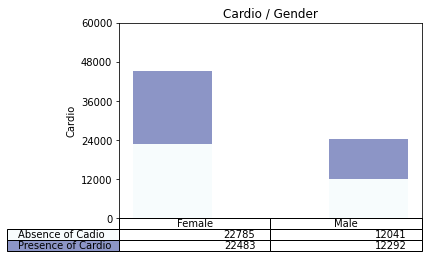

In [4]:
# show cardio / gender bar chart
data = [[df.filter('cardio = 0').filter('gender =1').count(), df.filter('cardio = 0').filter('gender = 2').count()],[df.filter('cardio = 1').filter('gender =1').count(), df.filter('cardio = 1').filter('gender = 2').count()]]
print(data)
columns = ('Female', 'Male')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Gender"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

[[32892, 1934], [32963, 1812]]


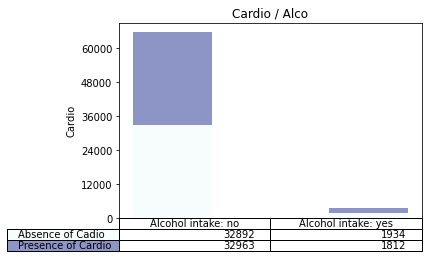

In [5]:
# show cardio / alco bar chart
data = [[df.filter('cardio = 0').filter('alco =0').count(), df.filter('cardio = 0').filter('alco = 1').count()],[df.filter('cardio = 1').filter('alco =0').count(), df.filter('cardio = 1').filter('alco = 1').count()]]
print(data)
columns = ('Alcohol intake: no', 'Alcohol intake: yes')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Alco"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

[[29159, 3780, 1887], [22912, 5719, 6144]]


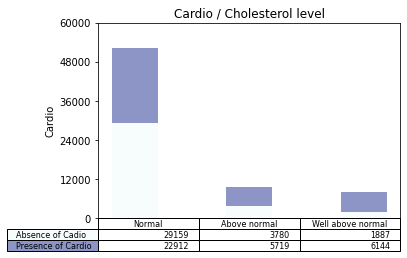

In [6]:
# show cardio / cholesterol bar chart
data = [[df.filter('cardio = 0').filter('cholesterol =1').count(), df.filter('cardio = 0').filter('cholesterol = 2').count(), df.filter('cardio = 0').filter('cholesterol = 3').count()],[df.filter('cardio = 1').filter('cholesterol =1').count(), df.filter('cardio = 1').filter('cholesterol = 2').count(),df.filter('cardio = 1').filter('cholesterol = 3').count()]]
print(data)
columns = ('Normal', 'Above normal', 'Well above normal')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Cholesterol level"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

[[30719, 2099, 2008], [28416, 3060, 3299]]


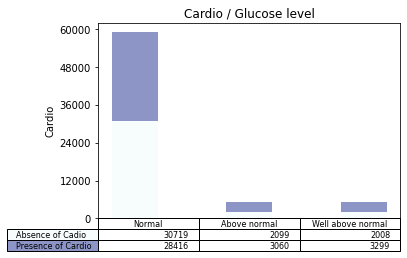

In [7]:
# show cardio / gluc bar chart
data = [[df.filter('cardio = 0').filter('gluc =1').count(), df.filter('cardio = 0').filter('gluc = 2').count(), df.filter('cardio = 0').filter('gluc = 3').count()],[df.filter('cardio = 1').filter('gluc =1').count(), df.filter('cardio = 1').filter('gluc = 2').count(),df.filter('cardio = 1').filter('gluc = 3').count()]]
print(data)
columns = ('Normal', 'Above normal', 'Well above normal')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Glucose level"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

[[31600, 3226], [31860, 2915]]


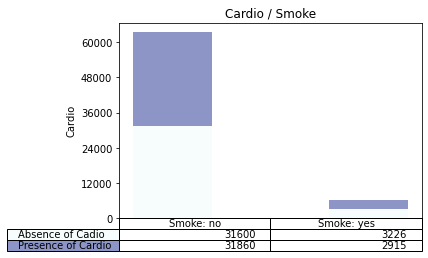

In [8]:
# show cardio / smoke bar chart
data = [[df.filter('cardio = 0').filter('smoke =0').count(), df.filter('cardio = 0').filter('smoke = 1').count()],[df.filter('cardio = 1').filter('smoke =0').count(), df.filter('cardio = 1').filter('smoke = 1').count()]]
print(data)
columns = ('Smoke: no', 'Smoke: yes')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Smoke"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

[[6348, 28478], [7310, 27465]]


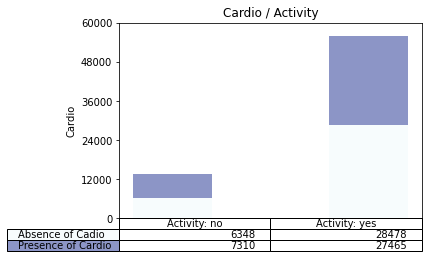

In [9]:
# show cardio / activity bar chart
data = [[df.filter('cardio = 0').filter('active =0').count(), df.filter('cardio = 0').filter('active = 1').count()],[df.filter('cardio = 1').filter('active =0').count(), df.filter('cardio = 1').filter('active = 1').count()]]
print(data)
columns = ('Activity: no', 'Activity: yes')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Activity"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

Cardio / Age


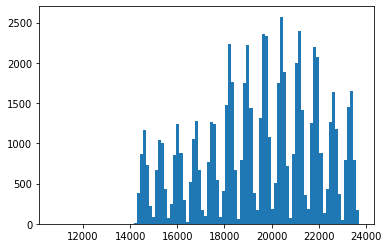

In [10]:
# Show age bar chart
ageArr = np.array(df.filter('age>0').select('age').collect())
plt.hist(ageArr, 100)
print('Cardio / Age')
plt.show()

Cardio / Ap_lo


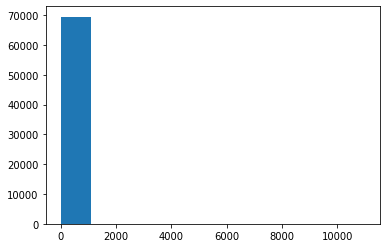

In [11]:
# Show ap_lo bar chart
ap_lo = np.array(df.filter('ap_lo>0').select('ap_lo').collect())
plt.hist(ap_lo, 10)
print('Cardio / Ap_lo')
plt.show()

Cardio / Ap_hi


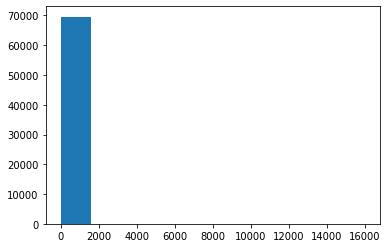

In [12]:
# Show ap_hi bar chart
ap_hi = np.array(df.filter('ap_hi>0').select('ap_hi').collect())
plt.hist(ap_hi, 10)
print('Cardio / Ap_hi')
plt.show()

Cardio / Weight


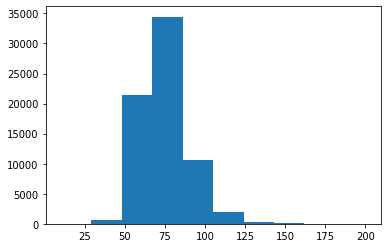

In [13]:
# Show weight bar chart
weight = np.array(df.filter('weight>0').select('weight').collect())
plt.hist(weight, 10)
print('Cardio / Weight')
plt.show()

Cardio / Height


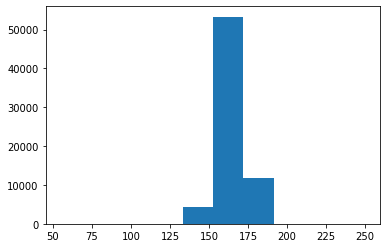

In [14]:
# Show height bar chart
height = np.array(df.filter('height>0').select('height').collect())
plt.hist(height, 10)
print('Cardio / Height')
plt.show()

In [15]:
# Checking for null/missing values
print('Get the list of the number of null value for each field')
df.toPandas().isnull().sum()

Get the list of the number of null value for each field


id               6
age              8
gender           0
height           2
weight         200
ap_hi           11
ap_lo            4
cholesterol      0
gluc             0
smoke            0
alco             0
active           0
cardio           0
dtype: int64

In [16]:
# Get correlations for cardio
correlations = []
for column in df.columns:
    correlations.append([column, df.corr('cardio', column, "pearson")])
schema = StructType([ 
    StructField("name",StringType(),True), 
    StructField("correlation",FloatType(),True)
  ])

corr_df = spark.createDataFrame(data=correlations,schema=schema)
corr_df.printSchema()
corr_df.show()

root
 |-- name: string (nullable = true)
 |-- correlation: float (nullable = true)



+-----------+-------------+
|       name|  correlation|
+-----------+-------------+
|         id| 0.0041427356|
|        age|   0.23773436|
|     gender|  0.008099986|
|     height| -0.009872831|
|     weight|   0.17463471|
|      ap_hi|  0.054296993|
|      ap_lo|    0.0674119|
|cholesterol|    0.2210763|
|       gluc|   0.08920544|
|      smoke| -0.015526061|
|       alco|-0.0075927465|
|     active|  -0.03516442|
|     cardio|          1.0|
+-----------+-------------+



In [3]:
df=df.drop('id')

In [4]:
# Drop rows with null values
df.na.drop().show()
print('before dropping missing values: ', df.count())
df=df.na.drop()
print('after dropping missing values: ', df.count())

+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|20228|     1|   156|    85|  140|   90|          3|   1|    0|   0|     1|     1|
|18857|     1|   165|    64|  130|   70|          3|   1|    0|   0|     0|     1|
|17623|     2|   169|    82|  150|  100|          1|   1|    0|   0|     1|     1|
|17474|     1|   156|    56|  100|   60|          1|   1|    0|   0|     0|     0|
|21914|     1|   151|    67|  120|   80|          2|   2|    0|   0|     0|     0|
|22113|     1|   157|    93|  130|   80|          3|   1|    0|   0|     1|     0|
|22584|     2|   178|    95|  130|   90|          3|   3|    0|   0|     1|     1|
|17668|     1|   158|    71|  110|   70|          1|   1|    0|   0|     1|     0|
|19834|     1|   164|    68|  110|   60|          1|   1|    0|   0|     0|     0|
|225

In [19]:
# Get outliers and extremes
height_low_quantile = df.select('height').toPandas().quantile(0.025)
height_high_quantile = df.select('height').toPandas().quantile(0.975)
weight_low_quantile = df.select('weight').toPandas().quantile(0.025)
weight_high_quantile = df.select('weight').toPandas().quantile(0.975)
print('height_low_quantile: ',height_low_quantile)
print('height_high_quantile: ',height_high_quantile)
print('weight_low_quantile: ',weight_low_quantile)
print('weight_high_quantile: ',weight_high_quantile)

ap_lo_low_quantile = df.select('ap_lo').toPandas().quantile(0.025)
ap_lo_high_quantile = df.select('ap_lo').toPandas().quantile(0.975)
ap_hi_low_quantile = df.select('ap_hi').toPandas().quantile(0.025)
ap_hi_high_quantile = df.select('ap_hi').toPandas().quantile(0.975)
print('ap_lo_low_quantile: ',ap_lo_low_quantile)
print('ap_lo_high_quantile: ',ap_lo_high_quantile)
print('ap_hi_low_quantile: ',ap_hi_low_quantile)
print('ap_hi_high_quantile: ',ap_hi_high_quantile)

height_low_quantile:  height    150.0
Name: 0.025, dtype: float64
height_high_quantile:  height    180.0
Name: 0.975, dtype: float64
weight_low_quantile:  weight    51.0
Name: 0.025, dtype: float64
weight_high_quantile:  weight    108.0
Name: 0.975, dtype: float64
ap_lo_low_quantile:  ap_lo    60.0
Name: 0.025, dtype: float64
ap_lo_high_quantile:  ap_lo    100.0
Name: 0.975, dtype: float64
ap_hi_low_quantile:  ap_hi    100.0
Name: 0.025, dtype: float64
ap_hi_high_quantile:  ap_hi    170.0
Name: 0.975, dtype: float64


Before removing extremes and outliners, there were 1223 cases where diastolic blook pressure is higher than systolic one. 


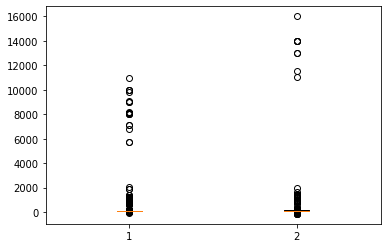

In [20]:
# Count how many ap_lo is greater than ap_hi before removing outliers
wrong_data = df.filter('ap_lo>ap_hi').count()
print('Before removing extremes and outliners, there were {} cases where diastolic blook pressure is higher than systolic one. '.format(wrong_data))
data= np.array(df.select('ap_lo','ap_hi').collect())
fig, ax=plt.subplots()
ax.boxplot(data)
plt.show()

In [5]:
# Removing outliers and extremes
print('Total number of rows before removing outliers and extreme values: ', df.count())
df=df.filter('height >= 150.0').filter('height <= 180.0')
df=df.filter('weight >= 51.0').filter('weight <= 108.0')

df=df.filter('ap_lo >= 60.0').filter('ap_lo <= 100.0')
df=df.filter('ap_hi >= 100.0').filter('ap_hi <= 170.0')
print('Total number of rows after removing outliers and extreme values: ', df.count())

Total number of rows before removing outliers and extreme values:  69377
Total number of rows after removing outliers and extreme values:  60558


In [22]:
print('After removing missing, outliers and extremes')
df.select(["age","gender","height","weight", "ap_hi"]).describe().show()
df.select(["ap_lo","cholesterol","gluc","smoke","alco","active"]).describe().show()
df.select(["cardio"]).describe().show()

After removing missing, outliers and extremes
+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|               age|            gender|            height|           weight|             ap_hi|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|             60558|             60558|             60558|            60558|             60558|
|   mean|19475.975345949337|1.3474685425542454|164.54602199544237|73.51966709600714|126.14544733974041|
| stddev| 2459.487128915687|0.4761700312219454| 6.841795541748977|11.84938874157776|14.296624159394991|
|    min|             10798|                 1|               150|               51|               100|
|    max|             23713|                 2|               180|              108|               170|
+-------+------------------+------------------+------------------+-----------------+------------------+

+-------+--------

Before removing extremes and outliners, there were 0 cases where diastolic blook pressure is higher than systolic one. 


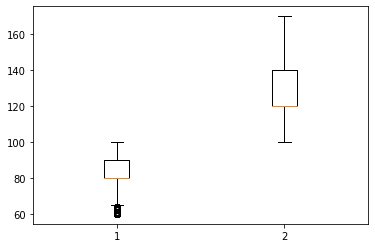

In [23]:
# Count how many ap_lo is greater than ap_hi after removing outliers
wrong_data = df.filter('ap_lo>ap_hi').count()
print('Before removing extremes and outliners, there were {} cases where diastolic blook pressure is higher than systolic one. '.format(wrong_data))
data= np.array(df.select('ap_lo','ap_hi').collect())
fig, ax=plt.subplots()
ax.boxplot(data)
plt.show()

In [6]:
df=df.withColumn('bmi', df.weight/((df.height/100)*(df.height/100)))

df=df.withColumn('bmi_cat', 
              when((df.bmi < 18.5), lit(1)) 
              .when((df.bmi >= 18.5) & (df.bmi < 25), lit(2))
              .when((df.bmi >= 25) & (df.bmi < 30), lit(3))
              .otherwise(lit(4)))

df=df.withColumn('ap_hi', 
              when((df.ap_hi < 120), lit(1)) 
              .when((df.ap_hi >= 120) & (df.ap_hi <= 129), lit(2))
              .when((df.ap_hi >= 130) & (df.ap_hi <= 139), lit(3))
              .when((df.ap_hi >= 140) & (df.ap_hi < 149), lit(4))
              .otherwise(lit(5)))

df=df.withColumn('ap_lo', 
              when((df.ap_lo < 80), lit(1)) 
              .when((df.ap_lo >= 80) & (df.ap_lo <= 89), lit(2))
              .when((df.ap_lo >= 90) & (df.ap_lo <= 120), lit(3))
              .otherwise(lit(4)))

df=df.withColumn('age', (df.age/365))
df=df.withColumn('age', col("age").cast("Integer"))

df=df.drop('weight','height','bmi')
df.show()

+---+------+-----+-----+-----------+----+-----+----+------+------+-------+
|age|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|bmi_cat|
+---+------+-----+-----+-----------+----+-----+----+------+------+-------+
| 55|     1|    4|    3|          3|   1|    0|   0|     1|     1|      4|
| 51|     1|    3|    1|          3|   1|    0|   0|     0|     1|      2|
| 48|     2|    5|    3|          1|   1|    0|   0|     1|     1|      3|
| 47|     1|    1|    1|          1|   1|    0|   0|     0|     0|      2|
| 60|     1|    2|    2|          2|   2|    0|   0|     0|     0|      3|
| 60|     1|    3|    2|          3|   1|    0|   0|     1|     0|      4|
| 61|     2|    3|    3|          3|   3|    0|   0|     1|     1|      3|
| 48|     1|    1|    1|          1|   1|    0|   0|     1|     0|      3|
| 54|     1|    1|    1|          1|   1|    0|   0|     0|     0|      3|
| 61|     1|    2|    2|          1|   1|    0|   0|     1|     0|      3|
| 51|     2|    2|    2| 

Cardio / Age


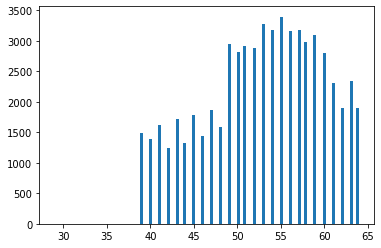

age_low_quantile:  age    40.0
Name: 0.025, dtype: float64
age_high_quantile:  age    64.0
Name: 0.975, dtype: float64


In [25]:
ageArr = np.array(df.filter('age>0').select('age').collect())
plt.hist(ageArr, 100)
print('Cardio / Age')
plt.show()

# Get outliers and extremes for age
age_low_quantile = df.select('age').toPandas().quantile(0.025)
age_high_quantile = df.select('age').toPandas().quantile(0.975)
print('age_low_quantile: ',age_low_quantile)
print('age_high_quantile: ',age_high_quantile)

Cardio / Age


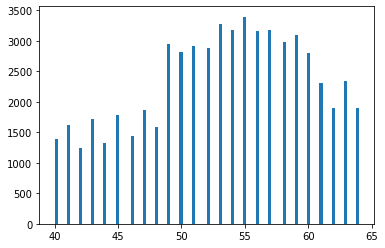

+---+------+-----+-----+-----------+----+-----+----+------+------+-------+
|age|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|bmi_cat|
+---+------+-----+-----+-----------+----+-----+----+------+------+-------+
| 55|     1|    4|    3|          3|   1|    0|   0|     1|     1|      4|
| 51|     1|    3|    1|          3|   1|    0|   0|     0|     1|      2|
| 48|     2|    5|    3|          1|   1|    0|   0|     1|     1|      3|
| 47|     1|    1|    1|          1|   1|    0|   0|     0|     0|      2|
| 60|     1|    2|    2|          2|   2|    0|   0|     0|     0|      3|
| 60|     1|    3|    2|          3|   1|    0|   0|     1|     0|      4|
| 61|     2|    3|    3|          3|   3|    0|   0|     1|     1|      3|
| 48|     1|    1|    1|          1|   1|    0|   0|     1|     0|      3|
| 54|     1|    1|    1|          1|   1|    0|   0|     0|     0|      3|
| 61|     1|    2|    2|          1|   1|    0|   0|     1|     0|      3|
| 51|     2|    2|    2| 

In [7]:
df=df.filter('age >= 40.0').filter('ap_lo <= 64.0')
ageArr = np.array(df.filter('age>0').select('age').collect())
plt.hist(ageArr, 100)
print('Cardio / Age')
plt.show()
df.show()

In [27]:
# After clean and formating
df.select(["age","gender", "ap_hi","ap_lo","cholesterol", "bmi_cat"]).describe().show()
df.select(["gluc","smoke","alco","active","cardio"]).describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              age|            gender|             ap_hi|             ap_lo|       cholesterol|           bmi_cat|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|            59060|             59060|             59060|             59060|             59060|             59060|
|   mean|53.21219099221131| 1.346613613274636|2.5982221469691837| 2.081832035218422|1.3589739248222148|2.8659329495428376|
| stddev|6.452132286928871|0.4758954202885047|1.2415154289052632|0.6730499640807206|0.6767240937594573|0.7826542927723298|
|    min|               40|                 1|                 1|                 1|                 1|                 1|
|    max|               64|                 2|                 5|                 3|                 3|                 4|
+-------+-------

[[29642, 29418]]


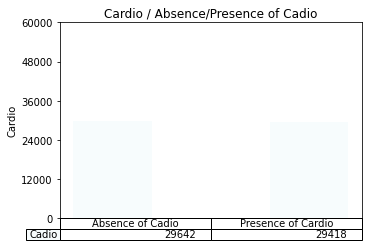

In [28]:
# show cardio distribution bar chart
data = [[df.filter('cardio = 0').count(), df.filter('cardio = 1').count()]]
print(data)
columns = ('Absence of Cadio', 'Presence of Cardio')
rows = ['Cadio']
x_label="Absence/Presence of Cadio"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

In [29]:
# Oversampling the data
major_df = df.filter('cardio = 0')
print('Number of absence of cardiovascular disease: {}'.format(df.filter('cardio = 0').count()))
minor_df = df.filter('cardio = 1')
print('Number of presense of cardiovascular disease: {}'.format(df.filter('cardio = 1').count()))
ratio = int(major_df.count()/minor_df.count())
print('Ratio of absence vs presence: {}'.format(ratio))
print('Total of records: {}'.format(df.count()))
a = range(ratio)

# duplicate the minority rows in this case the ratio is 1 so it does not duplicate rows
oversampled_df = minor_df.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop("dummy")

# combine both oversampled minority rows and previous majority rows
df = major_df.unionAll(oversampled_df)
print('Final total of records: {}'.format(df.count()))

Number of absence of cardiovascular disease: 29642
Number of presense of cardiovascular disease: 29418
Ratio of absence vs presence: 1
Total of records: 59060
Final total of records: 59060


In [8]:
# select data mining methods
inputCols=["age", "gender",  "ap_hi","ap_lo","cholesterol","gluc","smoke","alco","active","bmi_cat"]
assembler = VectorAssembler(inputCols=inputCols,outputCol="features")
output = assembler.transform(df)
indexer = StringIndexer(inputCol="cardio", outputCol="Cardio")
output_fixed = indexer.fit(output).transform(output)
final_data = output_fixed.select("features",'Cardio')
train_data, test_data = final_data.randomSplit([0.7, 0.3])

In [29]:
def printEvaluationMatrics(results, name):
    r = results.select(['prediction', 'Cardio'])
    predictionAndLabels=r.rdd
    metrics = MulticlassMetrics(predictionAndLabels)

    accuracy = metrics.accuracy
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats for %s" % name )
    print("Accuracy = %s" % accuracy)
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)

In [12]:
#Logistic regression
log_reg = LogisticRegression(featuresCol='features',labelCol='Cardio')
model_lr = log_reg.fit(train_data)
predictions_lr = model_lr.evaluate(test_data)
predictions_lr.predictions.show()
prediction_lr = model_lr.transform(test_data)
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'Cardio')
print("Logistic regression classifier AUC: {}".format(my_binary_eval.evaluate(prediction_lr)))


+--------------------+------+--------------------+--------------------+----------+
|            features|Cardio|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|[40.0,1.0,1.0,1.0...|   0.0|[1.95004070542984...|[0.87545108025746...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[1.95004070542984...|[0.87545108025746...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[1.95004070542984...|[0.87545108025746...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[1.95004070542984...|[0.87545108025746...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[2.18936106263884...|[0.89929005426803...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[2.18936106263884...|[0.89929005426803...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[2.18936106263884...|[0.89929005426803...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[2.18936106263884...|[0.89929005426803...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[2.18936106263884...|[0.89929005426803...|       0.0|
|[40

Logistic regression classifier AUC: 0.7802594598629424


In [13]:
# Naive Bayes Classifier
nb = NaiveBayes(featuresCol='features',labelCol='Cardio')
model_nb = nb.fit(train_data)
prediction_nb = model_nb.transform(test_data)
prediction_nb.show()
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'Cardio')
print("Naive Bayes classifier AUC: {}".format(my_binary_eval.evaluate(prediction_nb)))
printEvaluationMatrics(prediction_nb)

+--------------------+------+--------------------+--------------------+----------+
|            features|Cardio|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|[40.0,1.0,1.0,1.0...|   0.0|[-33.633837733412...|[0.57674595334240...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[-33.633837733412...|[0.57674595334240...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[-33.633837733412...|[0.57674595334240...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[-33.633837733412...|[0.57674595334240...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[-37.979330535160...|[0.60414648148484...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[-37.979330535160...|[0.60414648148484...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[-37.979330535160...|[0.60414648148484...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[-37.979330535160...|[0.60414648148484...|       0.0|
|[40.0,1.0,1.0,1.0...|   0.0|[-37.979330535160...|[0.60414648148484...|       0.0|
|[40

Naive Bayes classifier AUC: 0.2756540671332967


In [14]:
# Build models
# Decision tree 
dt = DecisionTreeClassifier(labelCol='Cardio',featuresCol='features')
model_dt = dt.fit(train_data)
prediction_dt = model_dt.transform(test_data)
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'Cardio')

print("Decision tree classifier AUC: {}".format(my_binary_eval.evaluate(prediction_dt)))
print(model_dt.toDebugString)

Decision tree classifier AUC: 0.5751710488083231
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_cf4deeb664d7, depth=5, numNodes=23, numClasses=2, numFeatures=10
  If (feature 2 <= 2.5)
   If (feature 0 <= 54.5)
    If (feature 4 <= 2.5)
     Predict: 0.0
    Else (feature 4 > 2.5)
     If (feature 5 <= 2.5)
      Predict: 1.0
     Else (feature 5 > 2.5)
      If (feature 9 <= 3.5)
       Predict: 0.0
      Else (feature 9 > 3.5)
       Predict: 1.0
   Else (feature 0 > 54.5)
    If (feature 4 <= 2.5)
     If (feature 0 <= 60.5)
      Predict: 0.0
     Else (feature 0 > 60.5)
      Predict: 1.0
    Else (feature 4 > 2.5)
     Predict: 1.0
  Else (feature 2 > 2.5)
   If (feature 2 <= 3.5)
    If (feature 4 <= 2.5)
     If (feature 0 <= 59.5)
      If (feature 3 <= 2.5)
       Predict: 0.0
      Else (feature 3 > 2.5)
       Predict: 1.0
     Else (feature 0 > 59.5)
      Predict: 1.0
    Else (feature 4 > 2.5)
     Predict: 1.0
   Else (feature 2 > 3.5)
    Predict: 1.0



In [15]:
# Gradient boosted tree
gbt = GBTClassifier(labelCol='Cardio',featuresCol='features')
model_gbt=gbt.fit(train_data)
prediction_gbt=model_gbt.transform(test_data)
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'Cardio')
print("Gradient boosted tree classifier AUC: {}".format(my_binary_eval.evaluate(prediction_gbt)))
print(model_gbt.toDebugString)

Gradient boosted tree classifier AUC: 0.7888678898334833
GBTClassificationModel: uid = GBTClassifier_67cd73920338, numTrees=20, numClasses=2, numFeatures=10
  Tree 0 (weight 1.0):
    If (feature 2 <= 2.5)
     If (feature 0 <= 54.5)
      If (feature 4 <= 2.5)
       If (feature 0 <= 44.5)
        If (feature 4 <= 1.5)
         Predict: -0.702906976744186
        Else (feature 4 > 1.5)
         Predict: -0.3785310734463277
       Else (feature 0 > 44.5)
        If (feature 2 <= 1.5)
         Predict: -0.5930232558139535
        Else (feature 2 > 1.5)
         Predict: -0.4293354726567723
      Else (feature 4 > 2.5)
       If (feature 5 <= 2.5)
        If (feature 9 <= 2.5)
         Predict: 0.3707865168539326
        Else (feature 9 > 2.5)
         Predict: 0.580110497237569
       Else (feature 5 > 2.5)
        If (feature 9 <= 3.5)
         Predict: -0.14814814814814814
        Else (feature 9 > 3.5)
         Predict: 0.30434782608695654
     Else (feature 0 > 54.5)
      If (featu

In [16]:
# Random forest tree
rfc = RandomForestClassifier(labelCol='Cardio',featuresCol='features')
model_rfc=rfc.fit(train_data)
prediction_rfc=model_rfc.transform(test_data)
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'Cardio')
print("Random Forest classifier accurary: {}".format(my_binary_eval.evaluate(prediction_rfc)))
print(model_rfc.toDebugString)

Random Forest classifier accurary: 0.7831107030450701
RandomForestClassificationModel: uid=RandomForestClassifier_1576b9d0789b, numTrees=20, numClasses=2, numFeatures=10
  Tree 0 (weight 1.0):
    If (feature 4 <= 1.5)
     If (feature 2 <= 2.5)
      Predict: 0.0
     Else (feature 2 > 2.5)
      If (feature 2 <= 3.5)
       Predict: 1.0
      Else (feature 2 > 3.5)
       If (feature 9 <= 1.5)
        If (feature 8 <= 0.5)
         Predict: 0.0
        Else (feature 8 > 0.5)
         Predict: 1.0
       Else (feature 9 > 1.5)
        Predict: 1.0
    Else (feature 4 > 1.5)
     If (feature 4 <= 2.5)
      If (feature 2 <= 3.5)
       If (feature 2 <= 2.5)
        Predict: 0.0
       Else (feature 2 > 2.5)
        If (feature 7 <= 0.5)
         Predict: 1.0
        Else (feature 7 > 0.5)
         Predict: 0.0
      Else (feature 2 > 3.5)
       Predict: 1.0
     Else (feature 4 > 2.5)
      If (feature 9 <= 2.5)
       If (feature 2 <= 2.5)
        If (feature 8 <= 0.5)
         Predi

In [17]:
# Build final model
df=df.withColumn('smoke',col('smoke').cast(StringType()))
df=df.withColumn('gender',col('gender').cast(StringType()))

df=df.withColumn('ap_hi',col('ap_hi').cast(StringType()))
df=df.withColumn('ap_lo',col('ap_lo').cast(StringType()))
df=df.withColumn('gluc',col('gluc').cast(StringType()))

df=df.withColumn('cholesterol',col('cholesterol').cast(StringType()))
df=df.withColumn('alco',col('alco').cast(StringType()))
df=df.withColumn('active',col('active').cast(StringType()))
df=df.withColumn('bmi_cat',col('bmi_cat').cast(StringType()))
df=df.withColumn('cardio',col('cardio').cast(StringType()))

major_df = df.filter('alco = 0')
print('Number of absence of cardiovascular disease: {}'.format(df.filter('cardio = 0').count()))
minor_df = df.filter('alco = 1')
print('Number of presense of cardiovascular disease: {}'.format(df.filter('cardio = 1').count()))
ratio = int(major_df.count()/minor_df.count())
print('Ratio of absence vs presence: {}'.format(ratio))
print('Total of records: {}'.format(df.count()))
a = range(ratio)

# duplicate the minority rows in this case the ratio is 1 so it does not duplicate rows
oversampled_df = minor_df.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop("dummy")

# combine both oversampled minority rows and previous majority rows
df = major_df.unionAll(oversampled_df)
print(df.count())

inputCols=["age", "gender_index",  "ap_hi_index","ap_lo_index","cholesterol_index","gluc_index","smoke_index","alco_index","active_index","bmi_cat_index"]
genderIndexer = StringIndexer().setInputCol("gender").setOutputCol("gender_index")
hiIndexer = StringIndexer().setInputCol("ap_hi").setOutputCol("ap_hi_index")
loIndexer = StringIndexer().setInputCol("ap_lo").setOutputCol("ap_lo_index")
cholendexer = StringIndexer().setInputCol("cholesterol").setOutputCol("cholesterol_index")
glucIndexer = StringIndexer().setInputCol("gluc").setOutputCol("gluc_index")
smokeIndexer = StringIndexer().setInputCol("smoke").setOutputCol("smoke_index")
alcoIndexer = StringIndexer().setInputCol("alco").setOutputCol("alco_index")
activeIndexer = StringIndexer().setInputCol("active").setOutputCol("active_index")
bmiIndexer = StringIndexer().setInputCol("bmi_cat").setOutputCol("bmi_cat_index")

assembler  = VectorAssembler().setInputCols(inputCols).setOutputCol("features")
    
labelIndexer = StringIndexer().setInputCol("cardio").setOutputCol("Cardio")
rt = RandomForestClassifier(labelCol='Cardio',featuresCol='features')
pipeline = Pipeline(stages=[genderIndexer,hiIndexer,loIndexer,cholendexer,glucIndexer,smokeIndexer,activeIndexer,alcoIndexer,bmiIndexer,labelIndexer,assembler,rt])
train_data, test_data = df.randomSplit([0.7, 0.3])
fit_model=pipeline.fit(train_data)
results = fit_model.transform(test_data)
print(fit_model.stages[11].toDebugString)

Number of absence of cardiovascular disease: 29642
Number of presense of cardiovascular disease: 29418
Ratio of absence vs presence: 18
Total of records: 59060
110927


RandomForestClassificationModel: uid=RandomForestClassifier_67c8060c25ba, numTrees=20, numClasses=2, numFeatures=10
  Tree 0 (weight 1.0):
    If (feature 4 in {1.0,2.0})
     If (feature 2 in {0.0,1.0})
      If (feature 7 in {1.0})
       If (feature 4 in {1.0})
        If (feature 3 in {1.0})
         Predict: 1.0
        Else (feature 3 not in {1.0})
         Predict: 0.0
       Else (feature 4 not in {1.0})
        Predict: 1.0
      Else (feature 7 not in {1.0})
       If (feature 2 in {1.0})
        If (feature 0 <= 52.5)
         Predict: 0.0
        Else (feature 0 > 52.5)
         Predict: 1.0
       Else (feature 2 not in {1.0})
        If (feature 4 in {1.0})
         Predict: 0.0
        Else (feature 4 not in {1.0})
         Predict: 1.0
     Else (feature 2 not in {0.0,1.0})
      If (feature 2 in {2.0})
       If (feature 4 in {1.0})
        If (feature 3 in {0.0,2.0})
         Predict: 0.0
        Else (feature 3 not in {0.0,2.0})
         Predict: 1.0
       Else (fea

In [18]:
features=["age", "gender",  "systolic blood pressure","diastolic blood pressure","cholesterol","glucose","smoking","alcohol","activity","bmi level"]
tree=fit_model.stages[11].toDebugString
for row in inputCols:
    index=inputCols.index(row)
    tree=tree.replace('feature '+str(index),features[index])
    
print(tree)
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'Cardio')
print("Random Forest classifier accurary: {}".format(my_binary_eval.evaluate(results)))

RandomForestClassificationModel: uid=RandomForestClassifier_67c8060c25ba, numTrees=20, numClasses=2, numFeatures=10
  Tree 0 (weight 1.0):
    If (cholesterol in {1.0,2.0})
     If (systolic blood pressure in {0.0,1.0})
      If (alcohol in {1.0})
       If (cholesterol in {1.0})
        If (diastolic blood pressure in {1.0})
         Predict: 1.0
        Else (diastolic blood pressure not in {1.0})
         Predict: 0.0
       Else (cholesterol not in {1.0})
        Predict: 1.0
      Else (alcohol not in {1.0})
       If (systolic blood pressure in {1.0})
        If (age <= 52.5)
         Predict: 0.0
        Else (age > 52.5)
         Predict: 1.0
       Else (systolic blood pressure not in {1.0})
        If (cholesterol in {1.0})
         Predict: 0.0
        Else (cholesterol not in {1.0})
         Predict: 1.0
     Else (systolic blood pressure not in {0.0,1.0})
      If (systolic blood pressure in {2.0})
       If (cholesterol in {1.0})
        If (diastolic blood pressure in {0

Random Forest classifier accurary: 0.8092028232738179


In [60]:
importances = fit_model.stages[11].featureImportances
print(importances)

(10,[0,1,2,3,4,5,6,7,8,9],[0.08363084334622664,0.0013890283476494535,0.4102793959601896,0.37183274734484195,0.11668755035099683,0.0023477670400210955,0.0032470491192389574,0.002551238101834585,0.0006254736788075929,0.00740890671019334])


In [20]:
AUC=my_binary_eval.evaluate(results)
print(AUC)

0.8092494377489736


[[57080, 53847]]


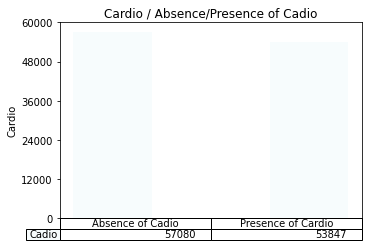

In [63]:
data = [[df.filter('cardio = 0').count(), df.filter('cardio = 1').count()]]
print(data)
columns = ('Absence of Cadio', 'Presence of Cardio')
rows = ['Cadio']
x_label="Absence/Presence of Cadio"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

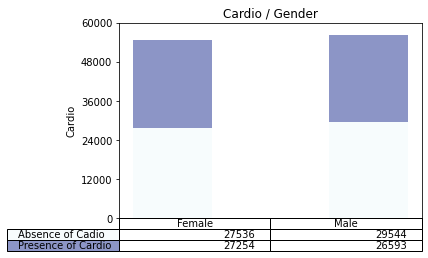

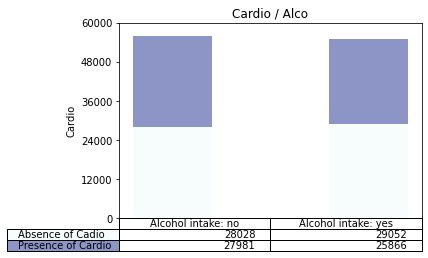

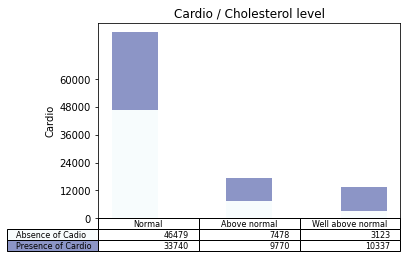

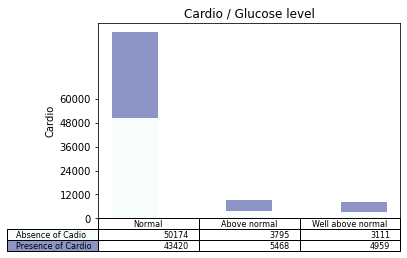

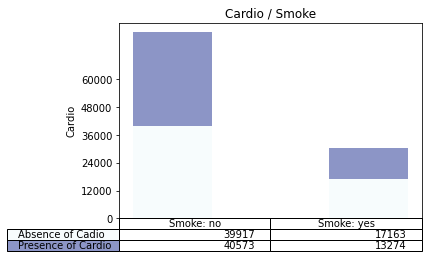

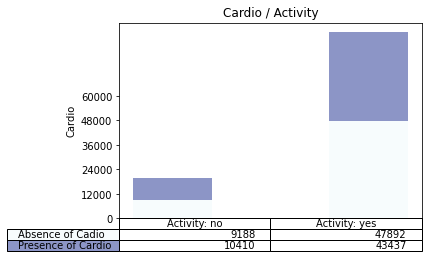

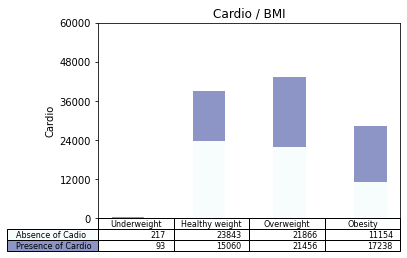

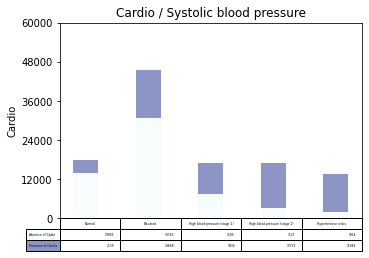

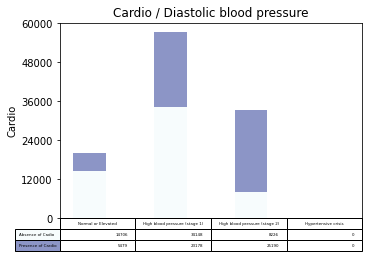

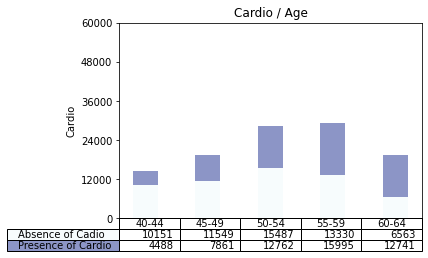

In [64]:
# show all charts
data = [[df.filter('cardio = 0').filter('gender =1').count(), df.filter('cardio = 0').filter('gender = 2').count()],[df.filter('cardio = 1').filter('gender =1').count(), df.filter('cardio = 1').filter('gender = 2').count()]]
columns = ('Female', 'Male')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Gender"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('alco =0').count(), df.filter('cardio = 0').filter('alco = 1').count()],[df.filter('cardio = 1').filter('alco =0').count(), df.filter('cardio = 1').filter('alco = 1').count()]]
columns = ('Alcohol intake: no', 'Alcohol intake: yes')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Alco"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('cholesterol =1').count(), df.filter('cardio = 0').filter('cholesterol = 2').count(), df.filter('cardio = 0').filter('cholesterol = 3').count()],[df.filter('cardio = 1').filter('cholesterol =1').count(), df.filter('cardio = 1').filter('cholesterol = 2').count(),df.filter('cardio = 1').filter('cholesterol = 3').count()]]
columns = ('Normal', 'Above normal', 'Well above normal')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Cholesterol level"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('gluc =1').count(), df.filter('cardio = 0').filter('gluc = 2').count(), df.filter('cardio = 0').filter('gluc = 3').count()],[df.filter('cardio = 1').filter('gluc =1').count(), df.filter('cardio = 1').filter('gluc = 2').count(),df.filter('cardio = 1').filter('gluc = 3').count()]]
columns = ('Normal', 'Above normal', 'Well above normal')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Glucose level"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('smoke =0').count(), df.filter('cardio = 0').filter('smoke = 1').count()],[df.filter('cardio = 1').filter('smoke =0').count(), df.filter('cardio = 1').filter('smoke = 1').count()]]
columns = ('Smoke: no', 'Smoke: yes')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Smoke"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('active =0').count(), df.filter('cardio = 0').filter('active = 1').count()],[df.filter('cardio = 1').filter('active =0').count(), df.filter('cardio = 1').filter('active = 1').count()]]
columns = ('Activity: no', 'Activity: yes')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Activity"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('bmi_cat =1').count(), df.filter('cardio = 0').filter('bmi_cat = 2').count(),df.filter('cardio = 0').filter('bmi_cat =3').count(), df.filter('cardio = 0').filter('bmi_cat = 4').count()],[df.filter('cardio = 1').filter('bmi_cat =1').count(), df.filter('cardio = 1').filter('bmi_cat = 2').count(),df.filter('cardio = 1').filter('bmi_cat =3').count(), df.filter('cardio = 1').filter('bmi_cat = 4').count()]]
columns = ('Underweight', 'Healthy weight', 'Overweight','Obesity')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="BMI"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('ap_hi =1').count(), df.filter('cardio = 0').filter('ap_hi = 2').count(),df.filter('cardio = 0').filter('ap_hi = 3').count(),df.filter('cardio = 0').filter('ap_hi = 4').count(),df.filter('cardio = 0').filter('ap_hi = 5').count()],[df.filter('cardio = 1').filter('ap_hi =1').count(), df.filter('cardio = 1').filter('ap_hi = 2').count(),df.filter('cardio = 1').filter('ap_hi = 3').count(),df.filter('cardio = 1').filter('ap_hi = 4').count(), df.filter('cardio = 1').filter('ap_hi = 5').count()]]
columns = ('Normal', 'Elevated', 'High blood pressure (stage 1)','High blood pressure (stage 2)', 'Hypertensive crisis')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Systolic blood pressure"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('ap_lo =1').count(), df.filter('cardio = 0').filter('ap_lo = 2').count(),df.filter('cardio = 0').filter('ap_lo = 3').count(),df.filter('cardio = 0').filter('ap_lo = 4').count()],[df.filter('cardio = 1').filter('ap_lo =1').count(), df.filter('cardio = 1').filter('ap_lo = 2').count(),df.filter('cardio = 1').filter('ap_lo = 3').count(),df.filter('cardio = 1').filter('ap_lo = 4').count()]]
columns = ('Normal or Elevated', 'High blood pressure (stage 1)','High blood pressure (stage 2)', 'Hypertensive crisis')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Diastolic blood pressure"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

data = [[df.filter('cardio = 0').filter('age>=40').filter('age<45').count(), df.filter('cardio = 0').filter('age>=45').filter('age<50').count(),df.filter('cardio = 0').filter('age>=50').filter('age<55').count(),df.filter('cardio = 0').filter('age>=55').filter('age<60').count(),df.filter('cardio = 0').filter('age>=60').filter('age<65').count()],[df.filter('cardio = 1').filter('age>=40').filter('age<45').count(), df.filter('cardio = 1').filter('age>=45').filter('age<50').count(),df.filter('cardio = 1').filter('age>=50').filter('age<55').count(),df.filter('cardio = 1').filter('age>=55').filter('age<60').count(),df.filter('cardio = 1').filter('age>=60').filter('age<65').count()]]
columns = ('40-44', '45-49','50-54', '55-59','60-64')
rows = ['Absence of Cadio', 'Presence of Cardio']
x_label="Age"
y_label="Cardio"
showBarChartForCategoricalField(data, columns,rows,x_label,y_label)

In [34]:
printEvaluationMatrics(results, 'Random Forest')

Summary Stats for Random Forest
Accuracy = 0.7447993497305596
Precision = 0.7831808212962262
Recall = 0.6486283352123262
F1 Score = 0.7095823769228135


In [31]:
printEvaluationMatrics(prediction_gbt, 'Gradient boost')

Summary Stats for Gradient boost
Accuracy = 0.7254167132788902
Precision = 0.7409351727505799
Recall = 0.6852981029810298
F1 Score = 0.7120314424825481


In [32]:
printEvaluationMatrics(prediction_dt, 'Decision Tree')

Summary Stats for Decision Tree
Accuracy = 0.7234589998881307
Precision = 0.751672671127123
Recall = 0.6596657633242999
F1 Score = 0.7026701948520567


In [33]:
printEvaluationMatrics(prediction_nb, 'Naive Bayes')

Summary Stats for Naive Bayes
Accuracy = 0.6881082895178432
Precision = 0.7180851063829787
Recall = 0.6097560975609756
F1 Score = 0.6595017098192476
